In [2]:
import pandas as pd
from datetime import date
from lifelines import KaplanMeierFitter, CoxPHFitter, AalenAdditiveFitter
import numpy as np
from sqlalchemy import create_engine
%matplotlib inline

In [87]:
#Import Data Sets
arrests = pd.read_table("nflarrests.csv", sep=",") #Table of Arrests
players = pd.read_table("players.csv", sep=",") #Table of Players Drafted

In [88]:
#Filter Data to Only Drafted Players After 2000
players_drafted = players[(players.draft_year.isnull() == False) & (players.draft_year >= 2000)]

In [89]:
#Join the Data Sets on Player Name
joined = pd.merge(players_drafted, arrests, how='left', on='name')

In [90]:
#Create Arrest Number - We don't want to consider 2nd, 3rd, Nth arrests. The analysis is how soon do drafted 
#players first get arrested. 
joined['arrest_rank'] = joined.groupby(['name'])['date'].rank(ascending=False)

In [91]:
#Fill in NA Values - If you've never been arrested we'll have blanks
joined['arrest_rank'] = joined['arrest_rank'].fillna(0)

In [92]:
#Filter to Only First Arrests
joined = joined[joined.arrest_rank <= 1]

In [93]:
#Create Sensor Variable - VERY IMPORTANT
joined['censor'] = joined['date'].notnull().astype(int) #Create Censor Variable

In [94]:
#Create Years Since Draft Variable for Time
joined['date'] = joined['date'].fillna('12-31-2015')
joined['date'] = pd.to_datetime(joined.date) #If you weren't arrested, this will be NA - fill with 2015
joined['year'] = joined.date.apply(lambda x: x.year) #Create 'Year' variable for Year of Arrest
joined['time_to_arrest'] = (joined['year'] - joined['draft_year']) + 1 #Finally Time to Arrest

In [95]:
#Filter out Corey Fuller and Anthony Davis for data quality - their records are not accurate
joined = joined[(joined['name'] != "Corey Fuller") & (joined['name'] != "Anthony Davis")]

In [96]:
#Filter to Only Players Drafted Since 2000 
joined = joined[joined['draft_year'] >= 2000]

In [97]:
#Clean the Draft Round Variable by removing the "th" "st" 
joined['d_round'] = joined.draft_round.apply(lambda x: int(x[:-2]))

In [98]:
#Get Counts of Draftees by College & Create "Other" College for Players
#drafted by schools that haven't placed more than 30 players in the NFL
college_counts = joined.college.value_counts()
sig_colleges = college_counts[college_counts > 15].index.tolist()
def over15(x):
    if x in sig_colleges: 
        return x
    else:
        return "Other"
joined["college_sig"] = joined.college.apply(lambda x: over15(x)) 

In [100]:
#Kaplan-Meier Curves!
from lifelines import KaplanMeierFitter, CoxPHFitter, AalenAdditiveFitter
kmf = KaplanMeierFitter()
kmf.fit(joined['time_to_arrest'], event_observed=joined['censor'])

<lifelines.KaplanMeierFitter: fitted with 3236 observations, 2906 censored>

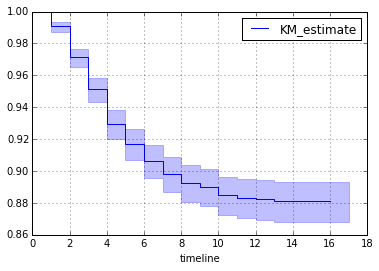

In [101]:
kmf.plot()

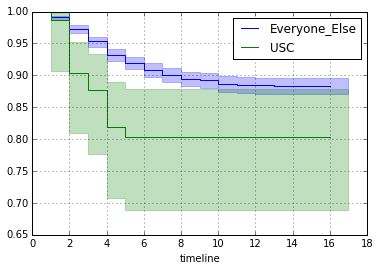

In [102]:
#Let's Slice this up by College - up first, the Trojans of USC
arrest = joined['time_to_arrest']
event = joined['censor']
college = joined['college']
rutgers = (college == 'USC')

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

kmf2.fit(arrest[~rutgers], event[~rutgers], label='Everyone_Else')
test = kmf2
ax = kmf2.plot()

kmf.fit(arrest[rutgers], event[rutgers], label='USC')
kmf.plot(ax=ax)

In [103]:
#Let's See if the Curves are Significantly Different
from lifelines.statistics import logrank_test
results = logrank_test(arrest[rutgers], arrest[~rutgers], event_observed_A=event[rutgers], event_observed_B=event[~rutgers])
results.print_summary()

Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00520 |              7.809 |      Reject Null    |        True       


In [108]:
#In order to write to a PostgresDB for Tableau, I experiment with transforming the data into a table format
x = kmf.timeline.tolist()
y = kmf.survival_function_.USC.tolist()
a = kmf2.timeline.tolist()
b = kmf2.survival_function_.Everyone_Else.tolist()
stat = results.is_significant #Grab the True/False for Significant Difference
pvalue = results.p_value #Grab the P-Value

In [109]:
data = {'years': x, 'curve': y}
df1 = pd.DataFrame(data)
df1['uid'] = 'test9999' #future application will need a UID to ensure each user gets the right data back
df1['group'] = 'USC'

In [110]:
data = {'years': a, 'curve': b}
df2 = pd.DataFrame(data)
df2['uid'] = 'test9999'
df2['group'] = 'Everyone Else'

In [111]:
table = df1.append(df2, ignore_index = True)
table['test'] = stat
table['pvalue'] = pvalue
table.head()

,curve,years,uid,group,test,pvalue
0,1.000000,0,test9999,USC,True,0.005197
1,0.986301,1,test9999,USC,True,0.005197
2,0.904110,2,test9999,USC,True,0.005197
3,0.876712,3,test9999,USC,True,0.005197
4,0.818265,4,test9999,USC,True,0.005197


In [86]:
#Sample Table code looks good. On to Python-Flask application code not featured here. 